<a href="https://colab.research.google.com/github/Santhosh-Suresh/pairs_trading/blob/master/Final_v7.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

<br>
<center><font size="6">Smart Cross-Asset Pairs Trading Strategy</font></center><br><br>
<center><font size="5"><i>WorldQuant University MScFE Capstone Project</i></font></center><br><br>
<center><font size="5">Ananta Narayana Satapathy</font></center><br>
<center><font size="5">Santhosh Suresh</font></center><br>
<center><font size="5">Vishwajith Thippeswamy</font></center><br>

# Imports

In [ ]:
# import the required libraries
import yfinance as yf
import pandas as pd
import numpy as np

import seaborn as sns
sns.set(style="whitegrid")
import matplotlib.pyplot as plt
from itertools import combinations

import statsmodels.api as sm
from statsmodels.tsa.stattools import coint, adfuller
from statsmodels.regression.linear_model import OLS

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler

import warnings
warnings.filterwarnings('ignore')

# Download the data

We download the data from yahoo Finance website. We take all the 500 stocks in S&P 500 and shortlist the financial stocks to have a smaller set with high correlation. Note that we choose more than 10 years of data to cover multiple regimes and business cycles.

In [ ]:
#Period Dates

start_date_1 = '2012-01-01'
end_date_1 =  '2022-12-31'

In [ ]:
# Get the list of S&P 500 tickers
sp500 = pd.read_html('https://en.wikipedia.org/wiki/List_of_S%26P_500_companies')[0]
tickers = sp500['Symbol'].tolist()
sectors = sp500['GICS Sector'].tolist()

#Shortlist names from one sector (financial sector) as they would have highest correlation
temp = pd.DataFrame(list(zip(tickers, sectors)),columns =['Ticker', 'Sector'])
temp = temp[temp['Sector'] == 'Financials']
tickers = temp['Ticker'].to_list()
tickers.remove("BRK.B")

In [ ]:
# Download the stock data for the given date range
sp500_data = yf.download(tickers, start=start_date_1, end=end_date_1)

# Extract the closing prices for each stock
closing_prices = sp500_data['Adj Close']

closing_prices.to_csv("stock_data.csv")

# Load the stock data into a DataFrame
df = pd.read_csv("stock_data.csv")

[*********************100%***********************]  71 of 71 completed


In [ ]:
# Converting index to date-time for easy reference
df = df.set_index('Date')
df.index = pd.to_datetime(df.index)
df

,ACGL,AFL,AIG,AIZ,AJG,ALL,AMP,AON,AXP,BAC,...,SYF,TFC,TROW,TRV,USB,V,WFC,WRB,WTW,ZION
Date,,,,,,,,,,,,,,,,,,,,,
2012-01-03,12.493333,16.888407,19.369776,32.779148,25.123665,21.838455,39.297573,41.674255,41.038826,4.872993,...,NaN,17.687889,40.076683,45.250175,19.892443,23.732393,20.490002,11.968402,82.552185,13.704865
2012-01-04,12.266667,16.771757,19.249056,32.376022,24.723669,21.688925,38.808754,40.974220,41.064365,4.881392,...,NaN,17.839302,40.000134,45.066071,19.885235,23.308392,20.583694,11.835535,82.084106,14.007237
2012-01-05,12.500000,16.880886,19.241014,32.589420,24.784052,21.830584,39.137165,41.204617,41.541073,5.301479,...,NaN,18.011368,40.563808,45.510986,20.180944,23.483522,20.915220,11.996368,83.509621,14.399505
2012-01-06,12.486667,16.647581,18.943264,32.542007,24.836885,22.050930,39.022610,40.885586,41.089901,5.192257,...,NaN,17.749834,40.856091,45.526333,20.015062,23.207005,20.857565,12.052315,82.807495,14.415850
2012-01-09,12.396667,16.267515,19.313435,32.289066,24.874607,22.145372,39.030243,40.991917,41.192051,5.267873,...,NaN,18.169666,40.501183,45.787128,20.368479,23.020355,21.117022,12.143222,82.105385,14.611982
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2022-12-23,63.380001,70.872345,62.738583,123.651848,187.858154,135.447662,305.707031,299.505463,145.971390,32.260765,...,32.296974,41.354996,109.848755,188.488724,42.155502,205.027939,40.404179,72.836166,242.673019,47.243732
2022-12-27,63.619999,71.356354,62.907452,123.196922,188.725601,135.100037,305.835938,299.884125,145.345886,32.320374,...,32.109604,41.597748,109.463211,189.483505,42.594620,205.486130,40.463337,73.292328,242.861694,47.624020
2022-12-28,62.599998,70.595772,62.470383,122.593643,187.399490,134.514023,302.017944,298.429413,142.982864,32.558830,...,31.655964,41.316154,106.843529,187.145798,42.301872,204.191208,40.542210,72.191605,240.041641,46.775681


In [ ]:
#remove tickers that don't have full 10 years history
df = df.dropna(axis='columns')
df

,ACGL,AFL,AIG,AIZ,AJG,ALL,AMP,AON,AXP,BAC,...,STT,TFC,TROW,TRV,USB,V,WFC,WRB,WTW,ZION
Date,,,,,,,,,,,,,,,,,,,,,
2012-01-03,12.493333,16.888407,19.369776,32.779148,25.123665,21.838455,39.297573,41.674255,41.038826,4.872993,...,32.024086,17.687889,40.076683,45.250175,19.892443,23.732393,20.490002,11.968402,82.552185,13.704865
2012-01-04,12.266667,16.771757,19.249056,32.376022,24.723669,21.688925,38.808754,40.974220,41.064365,4.881392,...,31.625885,17.839302,40.000134,45.066071,19.885235,23.308392,20.583694,11.835535,82.084106,14.007237
2012-01-05,12.500000,16.880886,19.241014,32.589420,24.784052,21.830584,39.137165,41.204617,41.541073,5.301479,...,31.978149,18.011368,40.563808,45.510986,20.180944,23.483522,20.915220,11.996368,83.509621,14.399505
2012-01-06,12.486667,16.647581,18.943264,32.542007,24.836885,22.050930,39.022610,40.885586,41.089901,5.192257,...,31.978149,17.749834,40.856091,45.526333,20.015062,23.207005,20.857565,12.052315,82.807495,14.415850
2012-01-09,12.396667,16.267515,19.313435,32.289066,24.874607,22.145372,39.030243,40.991917,41.192051,5.267873,...,31.985800,18.169666,40.501183,45.787128,20.368479,23.020355,21.117022,12.143222,82.105385,14.611982
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2022-12-23,63.380001,70.872345,62.738583,123.651848,187.858154,135.447662,305.707031,299.505463,145.971390,32.260765,...,76.221153,41.354996,109.848755,188.488724,42.155502,205.027939,40.404179,72.836166,242.673019,47.243732
2022-12-27,63.619999,71.356354,62.907452,123.196922,188.725601,135.100037,305.835938,299.884125,145.345886,32.320374,...,75.886719,41.597748,109.463211,189.483505,42.594620,205.486130,40.463337,73.292328,242.861694,47.624020
2022-12-28,62.599998,70.595772,62.470383,122.593643,187.399490,134.514023,302.017944,298.429413,142.982864,32.558830,...,75.581795,41.316154,106.843529,187.145798,42.301872,204.191208,40.542210,72.191605,240.041641,46.775681


# Choosing the pairs

In this section, we try to decide the pairs based on- 
* Correlation test
* Cointegration test
* Stationarity

First we reduce the number of pairs by quickly choosing only the top 100 pairs with the highest correlation, with a minimum threshold of 90%.

In [ ]:
# Calculate the correlation matrix of the stock data
corr_matrix_1 = df.corr()

# Find top 100 pairs of stocks with highest correlation
# Cointegration and stationarity tests will be run on these pairs only

# get pairs with highest correlation
n_pairs = 100
corr_threshold = 0.9
top_pairs_1 = []
for i, j in combinations(corr_matrix_1.columns, 2):
    if abs(corr_matrix_1.loc[i, j]) > corr_threshold:
        top_pairs_1.append((i, j))
        
top_pairs_1 = sorted(top_pairs_1, key=lambda x: abs(corr_matrix_1.loc[x[0], x[1]]), reverse=True)[:n_pairs]

#for pair in top_pairs_1:
#    print(f'{pair[0]} and {pair[1]} are one of the highly correlated pair with with correlation value of: {round(corr_matrix_1.loc[pair[0],pair[1]],3)}')

In [ ]:
top_pairs_1 = sorted(top_pairs_1)
print(top_pairs_1)

[('ACGL', 'CB'), ('ACGL', 'RE'), ('AFL', 'TRV'), ('AJG', 'AON'), ('AJG', 'BRO'), ('AJG', 'FDS'), ('AJG', 'MMC'), ('AJG', 'NDAQ'), ('AJG', 'PGR'), ('AJG', 'WRB'), ('AMP', 'MET'), ('AMP', 'MS'), ('AMP', 'RJF'), ('AON', 'BRO'), ('AON', 'FDS'), ('AON', 'MMC'), ('AON', 'NDAQ'), ('AON', 'PGR'), ('AON', 'SPGI'), ('AON', 'WRB'), ('AON', 'WTW'), ('BAC', 'FITB'), ('BAC', 'JPM'), ('BAC', 'NTRS'), ('BAC', 'PNC'), ('BAC', 'RF'), ('BAC', 'TFC'), ('BAC', 'ZION'), ('BLK', 'MCO'), ('BRO', 'FDS'), ('BRO', 'MMC'), ('BRO', 'MSCI'), ('BRO', 'NDAQ'), ('BRO', 'PGR'), ('BRO', 'SPGI'), ('CB', 'HIG'), ('CB', 'TRV'), ('CME', 'V'), ('DFS', 'FITB'), ('FDS', 'MMC'), ('FDS', 'NDAQ'), ('FDS', 'PGR'), ('FDS', 'SPGI'), ('FIS', 'GPN'), ('FISV', 'GPN'), ('FISV', 'V'), ('FITB', 'PNC'), ('FITB', 'RF'), ('FITB', 'SCHW'), ('FITB', 'ZION'), ('GL', 'RE'), ('GS', 'MS'), ('HBAN', 'KEY'), ('HBAN', 'TFC'), ('HIG', 'TRV'), ('ICE', 'JPM'), ('ICE', 'MA'), ('ICE', 'MCO'), ('ICE', 'SPGI'), ('ICE', 'V'), ('ICE', 'WTW'), ('JKHY', 'V'), (

In [ ]:
unique_items_1 = sorted(set(sum(top_pairs_1, ())))  # Join the tuples and convert to set
print(list(unique_items_1))

['ACGL', 'AFL', 'AJG', 'AMP', 'AON', 'BAC', 'BLK', 'BRO', 'CB', 'CME', 'DFS', 'FDS', 'FIS', 'FISV', 'FITB', 'GL', 'GPN', 'GS', 'HBAN', 'HIG', 'ICE', 'JKHY', 'JPM', 'KEY', 'MA', 'MCO', 'MET', 'MMC', 'MS', 'MSCI', 'NDAQ', 'NTRS', 'PGR', 'PNC', 'RE', 'RF', 'RJF', 'SCHW', 'SPGI', 'TFC', 'TRV', 'V', 'WRB', 'WTW', 'ZION']


In [ ]:
top_df = df[sorted(unique_items_1)]
top_df.to_csv("top_stock_data.csv")
top_df

,ACGL,AFL,AJG,AMP,AON,BAC,BLK,BRO,CB,CME,...,RF,RJF,SCHW,SPGI,TFC,TRV,V,WRB,WTW,ZION
Date,,,,,,,,,,,,,,,,,,,,,
2012-01-03,12.493333,16.888407,25.123665,39.297573,41.674255,4.872993,135.526703,10.009220,54.670624,30.143473,...,3.259718,18.187130,10.203046,37.742764,17.687889,45.250175,23.732393,11.968402,82.552185,13.704865
2012-01-04,12.266667,16.771757,24.723669,38.808754,40.974220,4.881392,134.547333,9.815468,54.149815,29.576511,...,3.252224,18.158749,10.220466,37.321297,17.839302,45.066071,23.308392,11.835535,82.084106,14.007237
2012-01-05,12.500000,16.880886,24.784052,39.137165,41.204617,5.301479,134.076279,9.850698,54.305271,29.283213,...,3.387110,18.686487,10.386021,37.965904,18.011368,45.510986,23.483522,11.996368,83.509621,14.399505
2012-01-06,12.486667,16.647581,24.836885,39.022610,40.885586,5.192257,133.926758,9.863901,54.437405,28.716253,...,3.304680,18.607042,10.490578,38.023739,17.749834,45.526333,23.207005,12.052315,82.807495,14.415850
2012-01-09,12.396667,16.267515,24.874607,39.030243,40.991917,5.267873,134.016464,9.943171,54.686169,28.009390,...,3.394603,18.709188,10.560281,38.230362,18.169666,45.787128,23.020355,12.143222,82.105385,14.611982
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2022-12-23,63.380001,70.872345,187.858154,305.707031,299.505463,32.260765,698.877441,56.725937,218.677155,167.809158,...,21.024963,106.445320,81.087814,331.235443,41.354996,188.488724,205.027939,72.836166,242.673019,47.243732
2022-12-27,63.619999,71.356354,188.725601,305.835938,299.884125,32.320374,698.202332,57.144360,219.921616,166.666107,...,21.242943,105.642151,81.534073,329.623749,41.597748,189.483505,205.486130,73.292328,242.861694,47.624020
2022-12-28,62.599998,70.595772,187.399490,302.017944,298.429413,32.558830,695.293396,56.357330,218.846420,166.924530,...,21.054688,105.364510,81.662987,327.912537,41.316154,187.145798,204.191208,72.191605,240.041641,46.775681


## Cross-assets data

Now we load the data for cross-assets such as bitcoin, gold, brent crude oil and USD generic currency. And re-run the test to obtain the top 100 correlated pairs including the above cross assets.

In [ ]:
# Load the other assets data into into top_df

# Download the other assets data for the given date range
bitcoin_data = yf.download("BTC-USD", start=start_date_1, end=end_date_1)
gold_data = yf.download("GLD", start=start_date_1, end=end_date_1)
brent_crude_oil_data = yf.download("BZ=F", start=start_date_1, end=end_date_1)
usd_index_data = yf.download("DX-Y.NYB", start=start_date_1, end=end_date_1)

# Extract the closing prices of all the assets
btc_closing_prices = bitcoin_data['Adj Close']
gld_closing_prices = gold_data['Adj Close']
oil_closing_prices = brent_crude_oil_data['Adj Close']
usd_closing_prices = usd_index_data['Adj Close']

# converting prices of other assets into dataframes
df_btc = btc_closing_prices.to_frame().rename(columns={"Adj Close": 'BTC'})
df_gld = gld_closing_prices.to_frame().rename(columns={"Adj Close": 'GOLD'})
df_oil = oil_closing_prices.to_frame().rename(columns={"Adj Close": 'OIL'})
df_usd = usd_closing_prices.to_frame().rename(columns={"Adj Close": 'USD_Index'})

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


In [ ]:
#Merging all the assets in to a data frame
df2 = pd.merge(df_btc, df_gld, left_index=True, right_index=True)
df3 = pd.merge(df2, df_oil, left_index=True, right_index=True)
df4 = pd.merge(df3, df_usd, left_index=True, right_index=True)

top_df = pd.merge(top_df, df4, left_index=True, right_index=True)
top_df

,ACGL,AFL,AJG,AMP,AON,BAC,BLK,BRO,CB,CME,...,TFC,TRV,V,WRB,WTW,ZION,BTC,GOLD,OIL,USD_Index
Date,,,,,,,,,,,,,,,,,,,,,
2014-09-17,18.059999,23.580912,37.743622,103.261368,79.506012,14.261903,266.121216,15.016215,88.199791,57.266174,...,28.315168,77.007095,50.729958,17.778666,97.387093,24.395792,457.334015,117.540001,98.970001,84.699997
2014-09-18,18.183332,23.726450,37.702152,104.093674,80.337738,14.491523,269.244507,15.121155,89.339531,58.877201,...,28.596468,77.936256,50.944141,17.918577,97.935600,24.676682,424.440002,117.779999,97.699997,84.320000
2014-09-19,18.196667,23.609209,37.486519,103.342987,79.442032,14.414983,267.743347,14.984268,89.015083,58.792042,...,28.589060,77.796471,50.899414,17.830214,97.364227,24.792337,394.795990,117.089996,98.389999,84.800003
2014-09-22,18.233334,23.665806,37.146492,101.800774,79.058151,14.483021,264.402161,14.888453,88.698952,58.600384,...,28.352186,77.788239,50.341583,17.697674,95.855751,24.494923,402.152008,116.849998,96.970001,84.669998
2014-09-23,18.046667,23.390909,37.138199,101.074577,78.847961,14.500026,262.344086,14.774384,87.700645,57.578430,...,28.011656,76.924835,50.007355,17.550411,94.758682,24.181000,435.790985,117.599998,96.849998,84.660004
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2022-12-23,63.380001,70.872345,187.858154,305.707031,299.505463,32.260765,698.877441,56.725937,218.677155,167.809158,...,41.354996,188.488724,205.027939,72.836166,242.673019,47.243732,16796.953125,167.259995,83.919998,104.309998
2022-12-27,63.619999,71.356354,188.725601,305.835938,299.884125,32.320374,698.202332,57.144360,219.921616,166.666107,...,41.597748,189.483505,205.486130,73.292328,242.861694,47.624020,16717.173828,168.669998,84.330002,104.180000
2022-12-28,62.599998,70.595772,187.399490,302.017944,298.429413,32.558830,695.293396,56.357330,218.846420,166.924530,...,41.316154,187.145798,204.191208,72.191605,240.041641,46.775681,16552.572266,167.910004,83.260002,104.459999


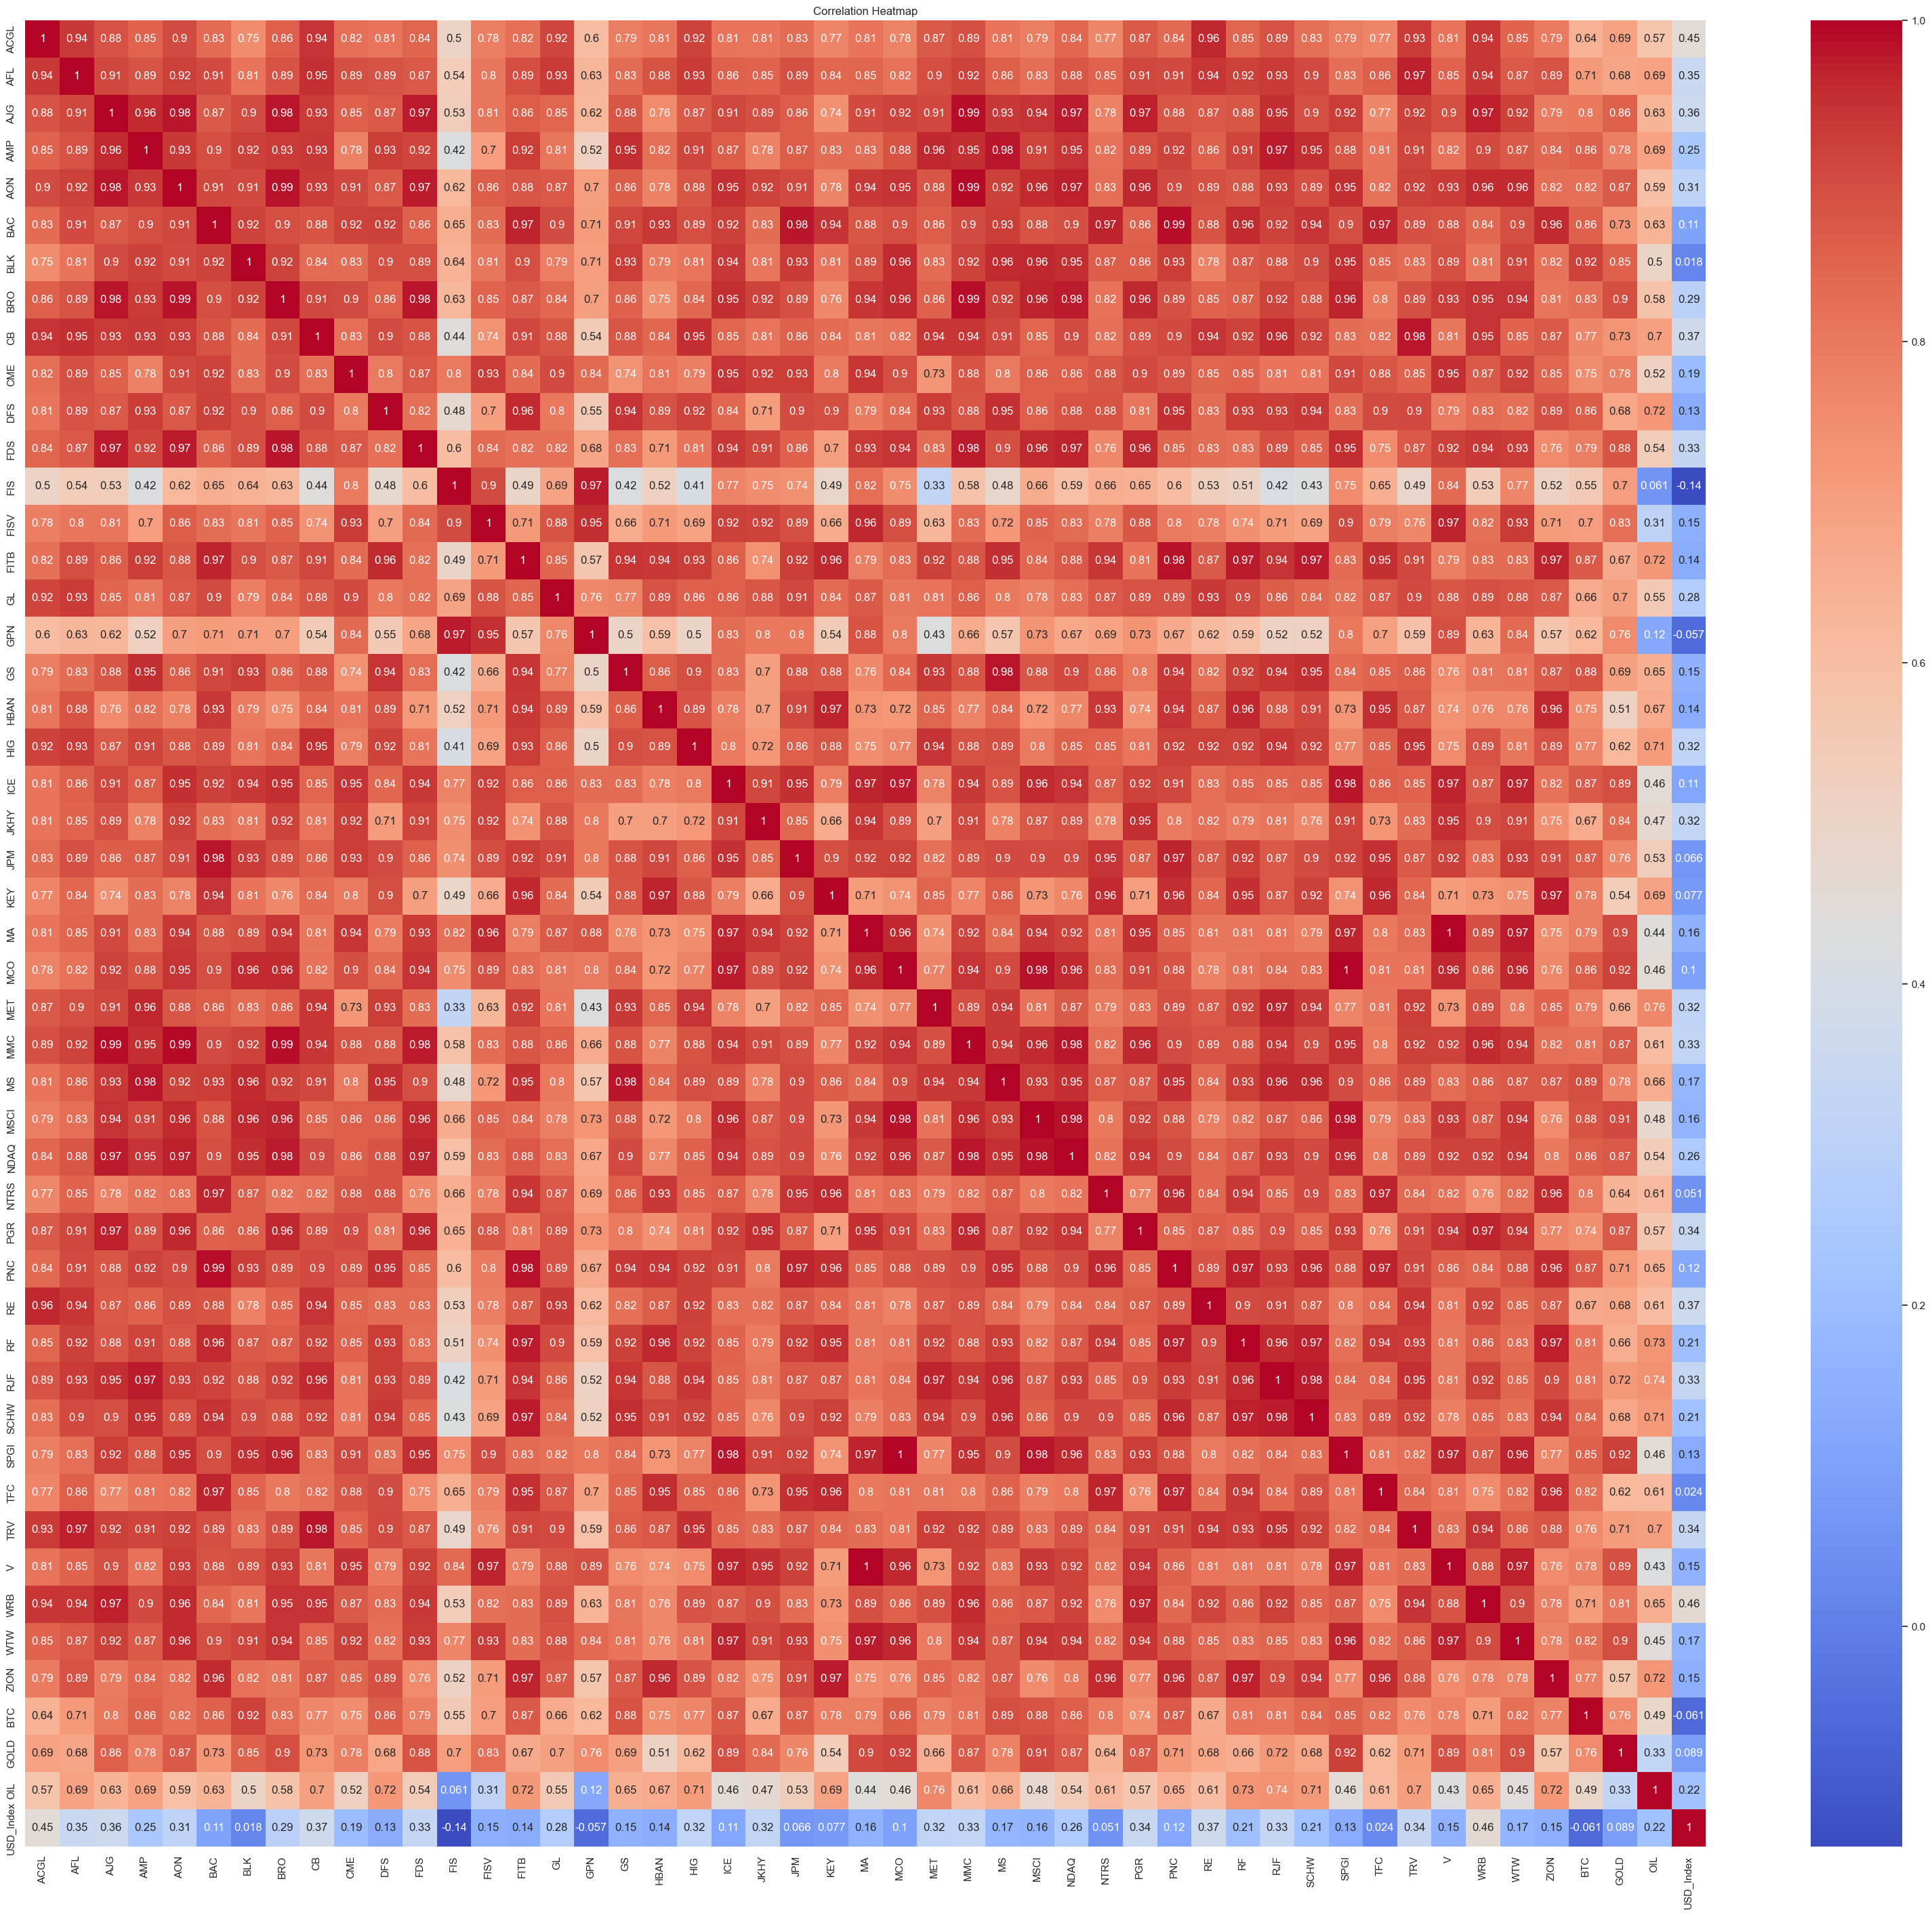

In [ ]:
# Calculate the correlation matrix of the stock data + other assets data
corr_matrix_2 = top_df.corr()

plt.figure(figsize=(40, 35))
sns.heatmap(corr_matrix_2, annot=True, cmap='coolwarm')

# Set plot title
plt.title('Correlation Heatmap')

# Display the plot
plt.show()

In [ ]:
# Find top 100 pairs of stocks with highest correlation in the new data set (including other assets data)

# Cointegration and stationarity tests will be run on these pairs only

# get pairs with highest correlation
n_pairs = 100
corr_threshold = 0.9
top_pairs_2 = []
for i, j in combinations(corr_matrix_2.columns, 2):
    if abs(corr_matrix_2.loc[i, j]) > corr_threshold:
        top_pairs_2.append((i, j))
        
top_pairs_2 = sorted(top_pairs_2, key=lambda x: abs(corr_matrix_2.loc[x[0], x[1]]), reverse=True)[:n_pairs]
#for pair in top_pairs_2:
#    print(f'{pair[0]} and {pair[1]} are one of the highly correlated pair with with correlation value of: {round(corr_matrix_2.loc[pair[0],pair[1]],3)}')

In [ ]:
unique_items_2 = sorted(set(sum(top_pairs_2, ())))  # Join the tuples and convert to set
print(list(unique_items_2))

['ACGL', 'AFL', 'AJG', 'AMP', 'AON', 'BAC', 'BLK', 'BRO', 'CB', 'DFS', 'FDS', 'FIS', 'FISV', 'FITB', 'GPN', 'GS', 'HBAN', 'ICE', 'JPM', 'KEY', 'MA', 'MCO', 'MET', 'MMC', 'MS', 'MSCI', 'NDAQ', 'NTRS', 'PGR', 'PNC', 'RE', 'RF', 'RJF', 'SCHW', 'SPGI', 'TFC', 'TRV', 'V', 'WRB', 'WTW', 'ZION']


We observe that the high correlation pairs do not include any of the cross assets. This is expected as correlation among assets within an industry is generally much higher than correlation with other assets or other financial products. Now we run all the tests on these high correlation pairs.

Before proceeding further, we split the data into training and test datasets. We will use the training dataset to shortlist and screen the most suitable pair based on our statistical testing and then run our trading with this pair on both the training and test dataset.

In [ ]:
# Split the data into training and test datasets
train, test = train_test_split(top_df, test_size=0.3, shuffle=False)
train

,ACGL,AFL,AJG,AMP,AON,BAC,BLK,BRO,CB,CME,...,TFC,TRV,V,WRB,WTW,ZION,BTC,GOLD,OIL,USD_Index
Date,,,,,,,,,,,,,,,,,,,,,
2014-09-17,18.059999,23.580912,37.743622,103.261368,79.506012,14.261903,266.121216,15.016215,88.199791,57.266174,...,28.315168,77.007095,50.729958,17.778666,97.387093,24.395792,457.334015,117.540001,98.970001,84.699997
2014-09-18,18.183332,23.726450,37.702152,104.093674,80.337738,14.491523,269.244507,15.121155,89.339531,58.877201,...,28.596468,77.936256,50.944141,17.918577,97.935600,24.676682,424.440002,117.779999,97.699997,84.320000
2014-09-19,18.196667,23.609209,37.486519,103.342987,79.442032,14.414983,267.743347,14.984268,89.015083,58.792042,...,28.589060,77.796471,50.899414,17.830214,97.364227,24.792337,394.795990,117.089996,98.389999,84.800003
2014-09-22,18.233334,23.665806,37.146492,101.800774,79.058151,14.483021,264.402161,14.888453,88.698952,58.600384,...,28.352186,77.788239,50.341583,17.697674,95.855751,24.494923,402.152008,116.849998,96.970001,84.669998
2014-09-23,18.046667,23.390909,37.138199,101.074577,78.847961,14.500026,262.344086,14.774384,87.700645,57.578430,...,28.011656,76.924835,50.007355,17.550411,94.758682,24.181000,435.790985,117.599998,96.849998,84.660004
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2020-06-29,28.370001,32.823437,92.260002,140.403351,183.830627,21.990335,498.895050,39.109688,119.565079,145.497269,...,32.550442,106.048393,187.481567,35.733116,185.758133,30.029030,9190.854492,166.630005,41.709999,97.540001
2020-06-30,28.650000,33.379292,94.015114,141.993271,188.108521,22.328791,509.399689,39.882683,120.440170,145.973206,...,33.268085,107.128616,189.235092,36.245567,189.628693,30.892191,9137.993164,167.369995,41.150002,97.389999
2020-07-01,28.150000,32.786369,93.880112,138.009018,186.682556,21.868114,509.615051,40.205578,119.527031,151.684998,...,32.258076,105.672676,189.832687,36.081078,187.991882,29.574728,9228.325195,166.619995,41.130001,97.199997


In [ ]:
test

,ACGL,AFL,AJG,AMP,AON,BAC,BLK,BRO,CB,CME,...,TFC,TRV,V,WRB,WTW,ZION,BTC,GOLD,OIL,USD_Index
Date,,,,,,,,,,,,,,,,,,,,,
2020-07-07,27.510000,32.073021,94.188713,138.292953,187.971771,21.633074,514.211975,39.872902,120.963333,148.730331,...,31.274652,105.653877,190.244110,35.897610,189.272430,28.657051,9252.277344,169.039993,43.080002,96.879997
2020-07-08,27.650000,32.795639,94.863777,140.450653,190.979919,21.717688,522.057739,40.186005,121.619659,150.948578,...,31.292372,106.311417,191.096390,35.922916,191.833572,28.784256,9428.333008,170.089996,43.290001,96.430000
2020-07-09,27.040001,31.470842,94.111549,135.605255,189.925110,21.407438,514.408630,40.019676,118.271439,148.658508,...,29.777365,103.361977,188.294662,35.302895,191.621765,27.657597,9277.967773,169.630005,42.349998,96.699997
2020-07-10,28.230000,32.304630,95.606316,140.611572,192.952835,22.582636,518.752686,40.528481,122.161819,147.814270,...,31.186058,106.931366,188.627731,36.574558,194.808670,29.265806,9278.807617,169.190002,43.240002,96.650002
2020-07-13,28.290001,32.313892,94.719116,140.053207,192.464478,22.742462,517.329712,40.068588,122.047691,148.362106,...,31.549301,107.307083,185.169601,37.036407,193.980682,29.874569,9243.614258,169.399994,42.720001,96.459999
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2022-12-23,63.380001,70.872345,187.858154,305.707031,299.505463,32.260765,698.877441,56.725937,218.677155,167.809158,...,41.354996,188.488724,205.027939,72.836166,242.673019,47.243732,16796.953125,167.259995,83.919998,104.309998
2022-12-27,63.619999,71.356354,188.725601,305.835938,299.884125,32.320374,698.202332,57.144360,219.921616,166.666107,...,41.597748,189.483505,205.486130,73.292328,242.861694,47.624020,16717.173828,168.669998,84.330002,104.180000
2022-12-28,62.599998,70.595772,187.399490,302.017944,298.429413,32.558830,695.293396,56.357330,218.846420,166.924530,...,41.316154,187.145798,204.191208,72.191605,240.041641,46.775681,16552.572266,167.910004,83.260002,104.459999


## Stationarity and Cointegration tests

First we check if all the asset prices are stationary using Augmented Dickey-Fuller test and eliminate the stationary assets from our dataset.

In [ ]:
def check_stationarity(x):
    result = adfuller(x)
    return result[0] < result[4]['5%']

In [ ]:
stationary_assets = []

for ticker in unique_items_2:
    stock = train[ticker]
    df1 = stock.to_frame()
    df1 = df1.dropna()
    if check_stationarity(df1):
        stationary_assets.append(ticker)

print("Number of stationary assets out of {} total assets: {}".format(len(unique_items_2), len(stationary_assets)))
print("Stationary assets:\n", stationary_assets)

Number of stationary assets out of 41 total assets: 1
Stationary assets:
 ['MET']


In [ ]:
# Removing stationary assets from top pairs list

for item in stationary_assets:
    top_pairs_2 = [tup for tup in top_pairs_2 if item not in tup]

Next we shortlist pairs which a have a stationary spread using Augmented Dickey-Fuller test. This is very important to ensure we only consider pairs where the spread tends to be mean-reverting. Without this behavior, we would not be able to exploit situations where the spread is deviating significantly from its mean. After checking for stationarity of spreads, we further reduce the dataset to include only the pairs that have stationary spreads and work with this reduced dataset going forward.

In [ ]:
def stationary_spreads(pairs):
      
    # Save a list of pairs whose spread is stationary
    res = []
    
    for i, pair in enumerate(pairs):
        stock1 = pair[0]
        stock2 = pair[1]
        
        # Run an OLS regression to calculate the beta and compute the spread
        regmodel=sm.OLS(train[stock2], train[stock1]).fit()
        # Use beta to calculate spread
        spread = train[stock2] - regmodel.params[0] * train[stock1]
        
        # check the stationarity of the spread
        if (check_stationarity(spread)):
            res.append(pair)
    return res

In [ ]:
stationary_pairs = stationary_spreads(top_pairs_2)
stationary_pairs = sorted(stationary_pairs)
stationary_pairs

[('AMP', 'MS'),
 ('BRO', 'NDAQ'),
 ('FITB', 'KEY'),
 ('FITB', 'PNC'),
 ('FITB', 'SCHW'),
 ('HBAN', 'KEY'),
 ('ICE', 'WTW'),
 ('NTRS', 'PNC'),
 ('NTRS', 'TFC'),
 ('PNC', 'SCHW'),
 ('RF', 'SCHW'),
 ('RF', 'ZION'),
 ('RJF', 'SCHW')]

In [ ]:
unique_items_stationary = sorted(set(sum(stationary_pairs, ())))  # Join the tuples and convert to set
print(list(unique_items_stationary))

['AMP', 'BRO', 'FITB', 'HBAN', 'ICE', 'KEY', 'MS', 'NDAQ', 'NTRS', 'PNC', 'RF', 'RJF', 'SCHW', 'TFC', 'WTW', 'ZION']


In [ ]:
train = train[sorted(unique_items_stationary)]
train.head(2).append(train.tail(2))

,AMP,BRO,FITB,HBAN,ICE,KEY,MS,NDAQ,NTRS,PNC,RF,RJF,SCHW,TFC,WTW,ZION
Date,,,,,,,,,,,,,,,,
2014-09-17,103.261368,15.016215,15.701232,7.365946,36.240135,10.334725,28.628345,12.678799,56.896114,67.836624,8.010008,32.423485,27.321264,28.315168,97.387093,24.395792
2014-09-18,104.093674,15.121155,15.905643,7.446167,36.638760,10.460582,29.087236,12.638331,57.246120,68.427994,8.133477,32.904713,27.845974,28.596468,97.935600,24.676682
2020-07-02,137.649414,39.970741,16.827442,7.583053,89.058487,10.267860,43.714153,38.575619,71.806107,92.209000,9.625295,43.238708,32.107998,32.266933,189.291702,29.447527
2020-07-06,142.144669,39.765266,17.090227,7.732950,89.319107,10.478301,44.656315,38.903351,72.758347,93.292221,9.806902,44.301594,32.896511,32.506149,190.138977,29.892738


In [ ]:
test = test[sorted(unique_items_stationary)]
test.head(2).append(test.tail(2))

,AMP,BRO,FITB,HBAN,ICE,KEY,MS,NDAQ,NTRS,PNC,RF,RJF,SCHW,TFC,WTW,ZION
Date,,,,,,,,,,,,,,,,
2020-07-07,138.292953,39.872902,16.365299,7.397885,89.357697,10.039881,43.439747,38.707352,71.972519,90.006470,9.380121,42.912167,32.588799,31.274652,189.272430,28.657051
2020-07-08,140.450653,40.186005,16.437788,7.441969,90.583641,10.171404,44.738644,39.102554,74.108124,90.394630,9.389202,43.526840,33.108063,31.292372,191.833572,28.784256
2022-12-29,309.713440,57.433270,32.409435,13.943082,103.651665,16.885487,83.831932,61.631622,88.757149,154.501999,21.421288,107.079926,81.970406,41.947311,244.345901,47.858047
2022-12-30,308.781250,56.755829,32.409435,13.903639,102.148163,16.875799,83.615570,61.113628,87.775139,154.609680,21.361837,106.363213,82.565392,41.782238,243.688309,47.936050


We plot a Correlation heatmap to get a visual idea about the relationship among these assets

Text(0.5, 1.0, 'Correlation Matrix')

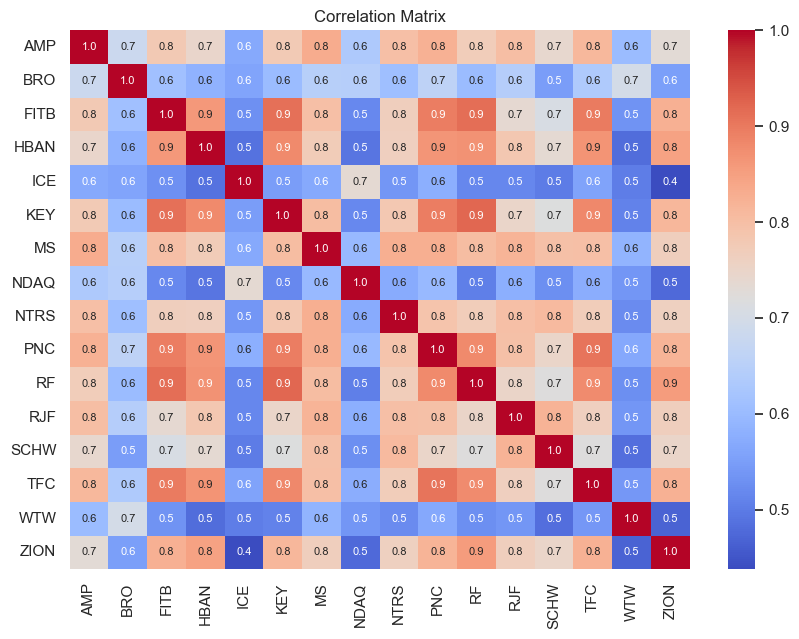

In [ ]:
fig, ax = plt.subplots(figsize=(10,7))
sns.heatmap(train.pct_change().corr(method ='pearson'), cmap='coolwarm', annot=True, fmt=".1f", annot_kws={"size":8})
ax.set_title('Correlation Matrix')

Finally we further shortlist the pairs which show high levels of Cointegration. Cointegration is a statistical method used to identify long-term relationships between assets, which is necessary for mean-reverting behavior. Cointegration tests, such as the Engle-Granger test or the Johansen test, can determine whether two time series move together in the long run. 

In [ ]:
# Function to shortlist cointegrated pairs
def cointegrated_pairs(dataset):
    n = dataset.shape[1]
    pval_matrix = np.ones((n, n))
    keys = dataset.keys()
    pairs = []
    for i in range(n):
        for j in range(i+1, n):
            res = coint(dataset[keys[i]], dataset[keys[j]])
            pval_matrix[i, j] = res[1]
            if res[1] < 0.05:
                pairs.append((keys[i], keys[j]))
    return pval_matrix, pairs

Text(0.5, 1.0, 'Cointegration Matrix p-values')

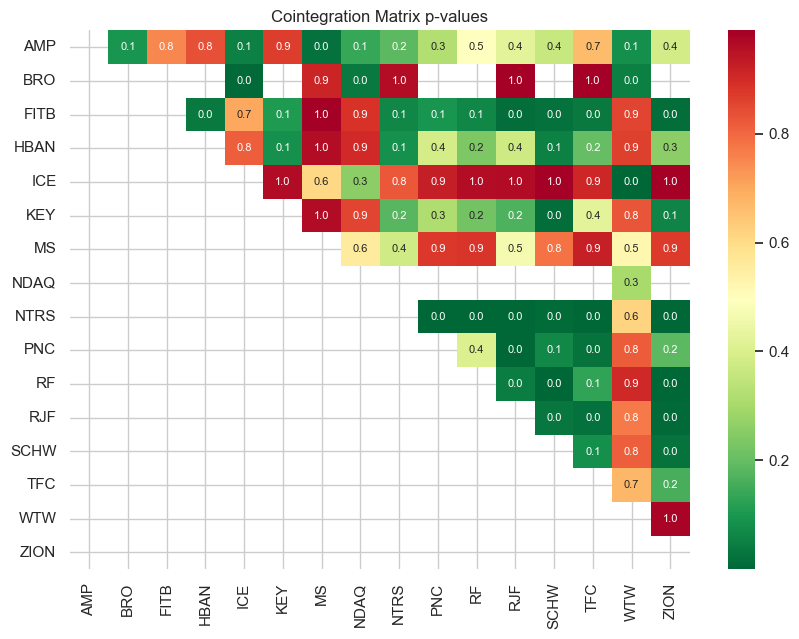

In [ ]:
# Compute and plot heatmap for p-values
pvalues, cointegrated_pairs = cointegrated_pairs(train)

fig, ax = plt.subplots(figsize=(10,7))
sns.set_style("whitegrid")
sns.heatmap(pvalues, xticklabels = train.columns, yticklabels = train.columns, cmap = 'RdYlGn_r', 
                    annot = True, fmt=".1f", annot_kws={"size":8}, mask = (pvalues >= 0.99))

ax.set_title('Cointegration Matrix p-values')

Below we summarize the results for pairs with stationary spreads and having Cointegration.

In [ ]:
print("Pairs of assets with Stationary spread:\n", stationary_pairs)

Pairs of assets with Stationary spread:
 [('AMP', 'MS'), ('BRO', 'NDAQ'), ('FITB', 'KEY'), ('FITB', 'PNC'), ('FITB', 'SCHW'), ('HBAN', 'KEY'), ('ICE', 'WTW'), ('NTRS', 'PNC'), ('NTRS', 'TFC'), ('PNC', 'SCHW'), ('RF', 'SCHW'), ('RF', 'ZION'), ('RJF', 'SCHW')]


In [ ]:
print("Pairs of assets that are Co-integrated:\n", cointegrated_pairs)

Pairs of assets that are Co-integrated:
 [('AMP', 'MS'), ('BRO', 'ICE'), ('BRO', 'NDAQ'), ('BRO', 'WTW'), ('FITB', 'HBAN'), ('FITB', 'RJF'), ('FITB', 'SCHW'), ('FITB', 'TFC'), ('FITB', 'ZION'), ('ICE', 'WTW'), ('KEY', 'SCHW'), ('NTRS', 'PNC'), ('NTRS', 'RF'), ('NTRS', 'RJF'), ('NTRS', 'SCHW'), ('NTRS', 'TFC'), ('NTRS', 'ZION'), ('PNC', 'RJF'), ('PNC', 'TFC'), ('RF', 'RJF'), ('RF', 'SCHW'), ('RF', 'ZION'), ('RJF', 'SCHW'), ('RJF', 'TFC'), ('RJF', 'ZION'), ('SCHW', 'ZION')]


We take the intersection of these two sets which will automatically include high correlation pairs only, given that we have chosen asset pairs with stationary spreads from the asset pairs with high correlation. This is the final shortlist of asset pairs which have a stationary spread, high correlation and well as are co-integrated.

In [ ]:
final_pairs = sorted(list(set(stationary_pairs) & set(cointegrated_pairs)))
final_pairs

[('AMP', 'MS'),
 ('BRO', 'NDAQ'),
 ('FITB', 'SCHW'),
 ('ICE', 'WTW'),
 ('NTRS', 'PNC'),
 ('NTRS', 'TFC'),
 ('RF', 'SCHW'),
 ('RF', 'ZION'),
 ('RJF', 'SCHW')]

In [ ]:
final_items = sorted(list(set(sum(final_pairs, ()))))  # Join the tuples and convert to set
print(final_items)

['AMP', 'BRO', 'FITB', 'ICE', 'MS', 'NDAQ', 'NTRS', 'PNC', 'RF', 'RJF', 'SCHW', 'TFC', 'WTW', 'ZION']


We will now backtest our trading strategies on these pairs to see which one performs best on training dataset as well as test dataset.

# Trading strategy and position evaluation

In this section, we use the z-score approach to evaluate the various trading strategies. First we evaluate using the training data set and then repeat the same on the test dataset.

## Signal Generation for Training Dataset

In order to generate signals, we compute the spreads between the two asset prices and check if their spreads is beyond +/- one standard deviation. When the spread is more than one standard deviation above the mean, we generate a sell signal for the first asset and a buy signal for the second asset. Likewise when the spread is more than one standard deviation below the mean, we generate a buy signal for the first asset and a sell signal for the second asset. 

In [ ]:
# Reduce the training dataset to have only the final pairs
train_data = train[list(final_items)]
train_data

,AMP,BRO,FITB,ICE,MS,NDAQ,NTRS,PNC,RF,RJF,SCHW,TFC,WTW,ZION
Date,,,,,,,,,,,,,,
2014-09-17,103.261368,15.016215,15.701232,36.240135,28.628345,12.678799,56.896114,67.836624,8.010008,32.423485,27.321264,28.315168,97.387093,24.395792
2014-09-18,104.093674,15.121155,15.905643,36.638760,29.087236,12.638331,57.246120,68.427994,8.133477,32.904713,27.845974,28.596468,97.935600,24.676682
2014-09-19,103.342987,14.984268,15.837502,36.593864,28.789354,12.690366,56.676346,68.389099,8.056310,32.687561,27.475060,28.589060,97.364227,24.792337
2014-09-22,101.800774,14.888453,15.739086,36.048008,28.322414,12.502470,56.594963,67.914421,7.979143,32.458706,27.303173,28.352186,95.855751,24.494923
2014-09-23,101.074577,14.774384,15.542251,35.823559,28.193600,12.305895,56.204262,66.918434,7.855676,31.930532,27.040810,28.011656,94.758682,24.181000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2020-06-29,140.403351,39.109688,16.981487,87.263008,43.211071,37.769150,70.539551,92.822830,9.861384,43.558849,31.492571,32.550442,185.758133,30.029030
2020-06-30,141.993271,39.882683,17.470821,88.421371,44.180660,38.386044,73.350037,94.971230,10.097478,44.071079,32.444557,33.268085,189.628693,30.892191
2020-07-01,138.009018,40.205578,16.700577,90.062386,43.549515,38.800533,71.131241,92.822830,9.652535,42.963387,31.752205,32.258076,187.991882,29.574728


In [ ]:
def generate_pairs_trades(price_data):
    num_assets = len(price_data.columns)
    
      
    # Generate trading signals for each pair
    signals = pd.DataFrame(index=price_data.index, columns = final_pairs, data = np.zeros((price_data.shape[0],len(final_pairs))))
  
    for i,pair in enumerate(final_pairs):
        asset1 = price_data.loc[:, pair[0]]
        asset2 = price_data.loc[:, pair[1]]
        
        # Calculate the spread between the two assets
        spread = asset1 - asset2
        
        # Calculate z-score of the spread
        zscore = (spread - np.mean(spread)) / np.std(spread)
        
        # Generate trading signals based on z-score thresholds
        signals[pair] += np.where(zscore > 1, -1, 0)  # Short asset1, long asset2
        signals[pair] += np.where(zscore < -1, 1, 0)  # Long asset1, short asset2
    
    return signals

In [ ]:
# Generate the trading signals for the training dataset
train_signals = generate_pairs_trades(train_data)
print(train_signals)

            (AMP, MS)  (BRO, NDAQ)  (FITB, SCHW)  (ICE, WTW)  (NTRS, PNC)  \
Date                                                                        
2014-09-17        0.0          0.0          -1.0         0.0         -1.0   
2014-09-18        0.0          0.0          -1.0         0.0         -1.0   
2014-09-19        0.0          0.0          -1.0         0.0         -1.0   
2014-09-22        0.0          0.0          -1.0        -1.0         -1.0   
2014-09-23        0.0          0.0          -1.0        -1.0         -1.0   
...               ...          ...           ...         ...          ...   
2020-06-29       -1.0          0.0           0.0         1.0          0.0   
2020-06-30       -1.0          0.0           0.0         1.0          0.0   
2020-07-01       -1.0          0.0           0.0         1.0          0.0   
2020-07-02       -1.0          0.0           0.0         1.0          0.0   
2020-07-06       -1.0          0.0           0.0         1.0          0.0   

In [ ]:
np.abs(train_signals).sum()

(AMP, MS)       539.0
(BRO, NDAQ)     427.0
(FITB, SCHW)    513.0
(ICE, WTW)      528.0
(NTRS, PNC)     597.0
(NTRS, TFC)     621.0
(RF, SCHW)      565.0
(RF, ZION)      697.0
(RJF, SCHW)     472.0
dtype: float64

We observe that roughly 500-600 signals are generated for each pair, which is a fair 40% proportion of all the 1456 trading days.

## Strategy evaluation for Training Dataset

In this section, we evaluate the trading strategy for the Sharpe Ratio, max drawdown and ROI.

We further make some simplifying assumptions during this initial build- 

1. Money can be borrowed at zero cost
2. No limits on shorting or selling 
3. No impact on the market
4. No trading costs or friction 
5. Trades occur at the closing price seamlessly 

We evaluate the strategies by multiplying the return on each day for each of the two asset in the pair by their respective position for that day, as given by the signals generated in the previous code cells. This gives the strategy return for each day, from the daily mean return and its standard deviation is obtained. These are then used to compute the Sharpe ratio and the ROI. We also compute the max drawdown by computing maximum performance drop from the maximum cumulative profit so far.

In [ ]:
def calculate_metrics(pricing_data, signals):
    metrics = pd.DataFrame(index=signals.columns, columns=['Sharpe Ratio', 'Max Drawdown', 'ROI', 'Correlation'])
   
    for i, pair in enumerate(signals.columns):
        asset1, asset2 = pair
        
        # Extract the prices for the pair
        prices_asset1 = pricing_data[asset1]
        prices_asset2 = pricing_data[asset2]
        
        # Extract the signals for the pair
        pair_signals = signals[pair][:-1]
        
        # Calculate daily returns
        returns = (prices_asset2.pct_change() - prices_asset1.pct_change()).dropna()
        
        # Calculate the strategy returns
        strategy_returns = pair_signals * returns
        
        # Calculate metrics
        daily_returns = strategy_returns.mean()
        std_dev = strategy_returns.std()
        sharpe_ratio = np.sqrt(252) * (daily_returns / std_dev)  # Assuming 252 trading days in a year
        max_drawdown = (strategy_returns.cumsum() - strategy_returns.cumsum().cummax()).min()
        roi = daily_returns*252   # annualized returns
        
        # Assign metrics to the DataFrame
        metrics.iloc[i, 0] = sharpe_ratio
        metrics.iloc[i,1] = max_drawdown
        metrics.iloc[i,2] = roi
        
        # Calculate correlation
        metrics.iloc[i,3] = corr_matrix_2.loc[asset1, asset2]
        
    return metrics

In [ ]:
# Calculate metrics for each pair-trading strategy
train_metrics = calculate_metrics(train_data, train_signals)

# Print the metrics
print(train_metrics)

             Sharpe Ratio Max Drawdown       ROI Correlation
(AMP, MS)        0.644775    -0.189456  0.088885    0.978753
(BRO, NDAQ)      0.558372    -0.168025  0.067301    0.975088
(FITB, SCHW)     0.608204    -0.171285  0.087262    0.974286
(ICE, WTW)       0.807818    -0.141657  0.128286    0.966838
(NTRS, PNC)      1.007125    -0.113597  0.109645    0.963331
(NTRS, TFC)      0.448303    -0.195875  0.050236    0.967012
(RF, SCHW)       0.218502    -0.206423  0.028325    0.970798
(RF, ZION)       0.294503    -0.177932  0.032685    0.970903
(RJF, SCHW)      0.969268    -0.112789   0.11779    0.975494


## Interpreting the results for Training Dataset

Below we draw graphs to illustrate the performance metrics for each pair. The first graph displays the Sharpe ratio (column) and max drawdown (heatmap) for each pair, while the second graph shows the Sharpe ratio (line) and the ROI (column) for each pair.

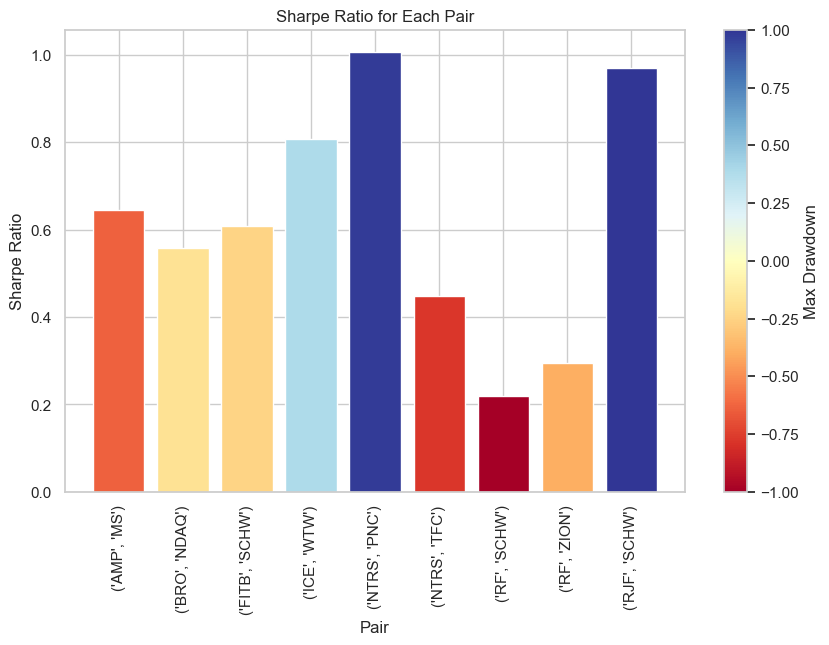

In [ ]:
pair_labels =  [str(i) for i in train_metrics.index]
sharpe_ratios = train_metrics['Sharpe Ratio']
drawdowns = train_metrics['Max Drawdown']

# Normalize drawdowns to range from 0 to 1
scaler = MinMaxScaler(feature_range=(0, 1))
scaler = scaler.fit(drawdowns.values.reshape(-1,1))

normalized_drawdowns = scaler.transform(drawdowns.values.reshape(-1,1))

# Create a color map based on the normalized drawdowns
colors = plt.cm.RdYlBu(normalized_drawdowns)

# Plot the bar chart
plt.figure(figsize=(10, 6))
plt.bar(pair_labels, sharpe_ratios, color=colors)
plt.title('Sharpe Ratio for Each Pair')
plt.xlabel('Pair')
plt.ylabel('Sharpe Ratio')
plt.xticks(rotation=90)

# Create a color bar legend for correlations
colorbar = plt.colorbar(plt.cm.ScalarMappable(norm=plt.Normalize(-1, 1), cmap=plt.cm.RdYlBu))
colorbar.set_label('Max Drawdown')

# Show the plot
plt.show()

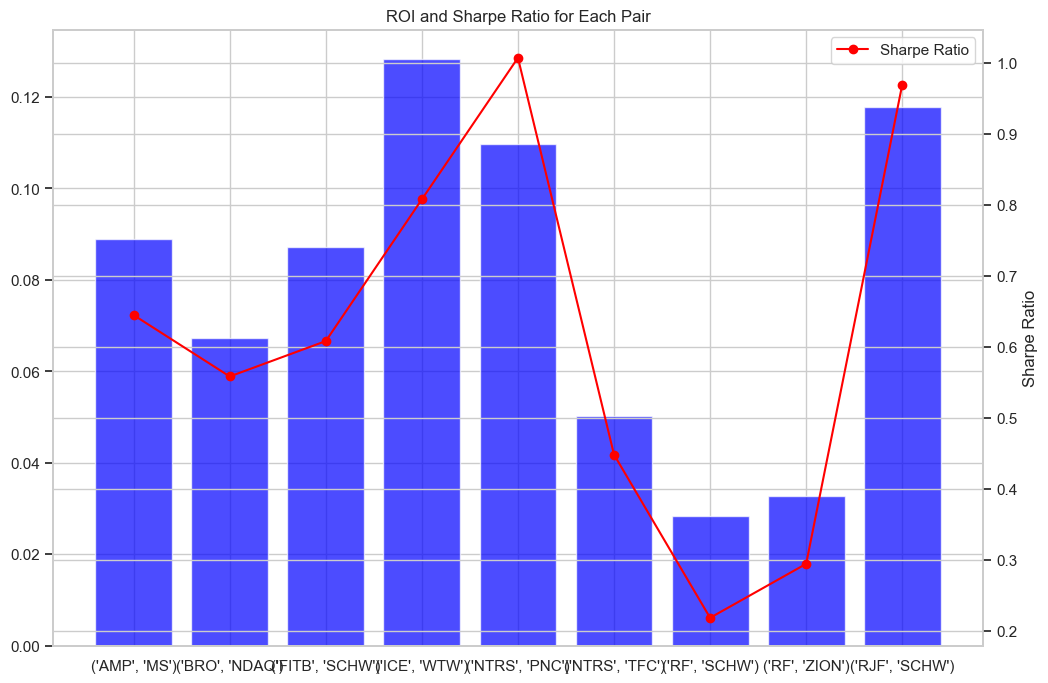

In [ ]:
# Extract the data for plotting
pair_labels = [str(i) for i in train_metrics.index]
roi_values = train_metrics['ROI']
sharpe_ratios = train_metrics['Sharpe Ratio']

# Set the figure size
plt.figure(figsize=(12,8))

# Plot the ROI as bars
plt.bar(pair_labels, roi_values, color='blue', alpha=0.7, label='ROI')

# Create a secondary y-axis for Sharpe ratio
ax = plt.gca().twinx()

# Plot the Sharpe ratio as a line
ax.plot(pair_labels, sharpe_ratios, color='red', marker='o', label='Sharpe Ratio')

# Set the axis labels
plt.xlabel('Pairs')
plt.ylabel('ROI')
ax.set_ylabel('Sharpe Ratio')

# Rotate the x-axis labels for better readability
plt.xticks(rotation='vertical')

# Set the title and legend
plt.title('ROI and Sharpe Ratio for Each Pair')
plt.legend()

# Show the plot
plt.show()

## Signal Generation and Strategy Evaluation for Test Dataset

Below, we use the same performance tests using the test dataset. Again, we draw graphs to illustrate the performance metrics for each pair. The first graph displays the Sharpe ratio (column) and max drawdown (heatmap) for each pair, while the second graph shows the Sharpe ratio (line) and the ROI (column) for each pair.

In [ ]:
# Reduce the test dataset to have only the final pairs
test_data = test[list(final_items)]
test_data

,AMP,BRO,FITB,ICE,MS,NDAQ,NTRS,PNC,RF,RJF,SCHW,TFC,WTW,ZION
Date,,,,,,,,,,,,,,
2020-07-07,138.292953,39.872902,16.365299,89.357697,43.439747,38.707352,71.972519,90.006470,9.380121,42.912167,32.588799,31.274652,189.272430,28.657051
2020-07-08,140.450653,40.186005,16.437788,90.583641,44.738644,39.102554,74.108124,90.394630,9.389202,43.526840,33.108063,31.292372,191.833572,28.784256
2020-07-09,135.605255,40.019676,15.758169,88.942627,43.458042,38.813385,70.641235,89.230148,8.926099,42.002956,32.579182,29.777365,191.621765,27.657597
2020-07-10,140.611572,40.528481,16.664330,89.338425,45.552727,39.481693,74.117371,91.712532,9.343801,44.141525,33.463860,31.186058,194.808670,29.265806
2020-07-13,140.053207,40.068588,16.945244,88.643379,45.936916,39.520241,75.411682,92.687431,9.516329,44.186337,33.108063,31.549301,193.980682,29.874569
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2022-12-23,305.707031,56.725937,31.691435,102.367218,84.687561,61.043896,87.318855,151.751251,21.024963,106.445320,81.087814,41.354996,242.673019,47.243732
2022-12-27,305.835938,57.144360,32.072788,101.670235,83.654907,60.745052,87.189911,152.671417,21.242943,105.642151,81.534073,41.597748,242.861694,47.624020
2022-12-28,302.017944,56.357330,31.994562,101.829544,83.064819,60.466133,86.356689,152.573532,21.054688,105.364510,81.662987,41.316154,240.041641,46.775681


In [ ]:
# Generate the trading signals for the test dataset
test_signals = generate_pairs_trades(test_data)
np.abs(test_signals).sum()

(AMP, MS)       231.0
(BRO, NDAQ)     238.0
(FITB, SCHW)    203.0
(ICE, WTW)      146.0
(NTRS, PNC)     178.0
(NTRS, TFC)     284.0
(RF, SCHW)      195.0
(RF, ZION)      225.0
(RJF, SCHW)     205.0
dtype: float64

In [ ]:
# Calculate metrics for each pair-trading strategy
test_metrics = calculate_metrics(test_data, test_signals)

# Print the metrics
print(test_metrics)

             Sharpe Ratio Max Drawdown       ROI Correlation
(AMP, MS)        1.288444    -0.184112  0.175297    0.978753
(BRO, NDAQ)      1.160636    -0.090622  0.178309    0.975088
(FITB, SCHW)     0.976038    -0.131459  0.166628    0.974286
(ICE, WTW)       1.547834    -0.086915  0.219283    0.966838
(NTRS, PNC)     -0.254366    -0.201991  -0.03107    0.963331
(NTRS, TFC)      1.888004    -0.071373  0.267417    0.967012
(RF, SCHW)       0.270431    -0.170031  0.047094    0.970798
(RF, ZION)       0.810208    -0.143285   0.09463    0.970903
(RJF, SCHW)      1.446705    -0.129029  0.192171    0.975494


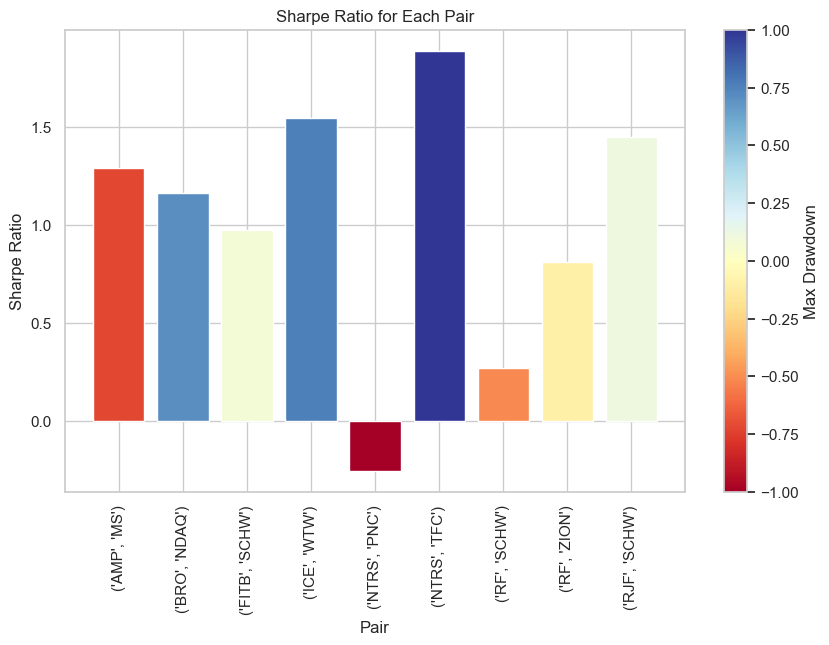

In [ ]:
pair_labels =  [str(i) for i in test_metrics.index]
sharpe_ratios = test_metrics['Sharpe Ratio']
drawdowns = test_metrics['Max Drawdown']

# Normalize drawdowns to range from 0 to 1
scaler = MinMaxScaler(feature_range=(0, 1))
scaler = scaler.fit(drawdowns.values.reshape(-1,1))

normalized_drawdowns = scaler.transform(drawdowns.values.reshape(-1,1))

# Create a color map based on the normalized drawdowns
colors = plt.cm.RdYlBu(normalized_drawdowns)

# Plot the bar chart
plt.figure(figsize=(10, 6))
plt.bar(pair_labels, sharpe_ratios, color=colors)
plt.title('Sharpe Ratio for Each Pair')
plt.xlabel('Pair')
plt.ylabel('Sharpe Ratio')
plt.xticks(rotation=90)

# Create a color bar legend for correlations
colorbar = plt.colorbar(plt.cm.ScalarMappable(norm=plt.Normalize(-1, 1), cmap=plt.cm.RdYlBu))
colorbar.set_label('Max Drawdown')

# Show the plot
plt.show()

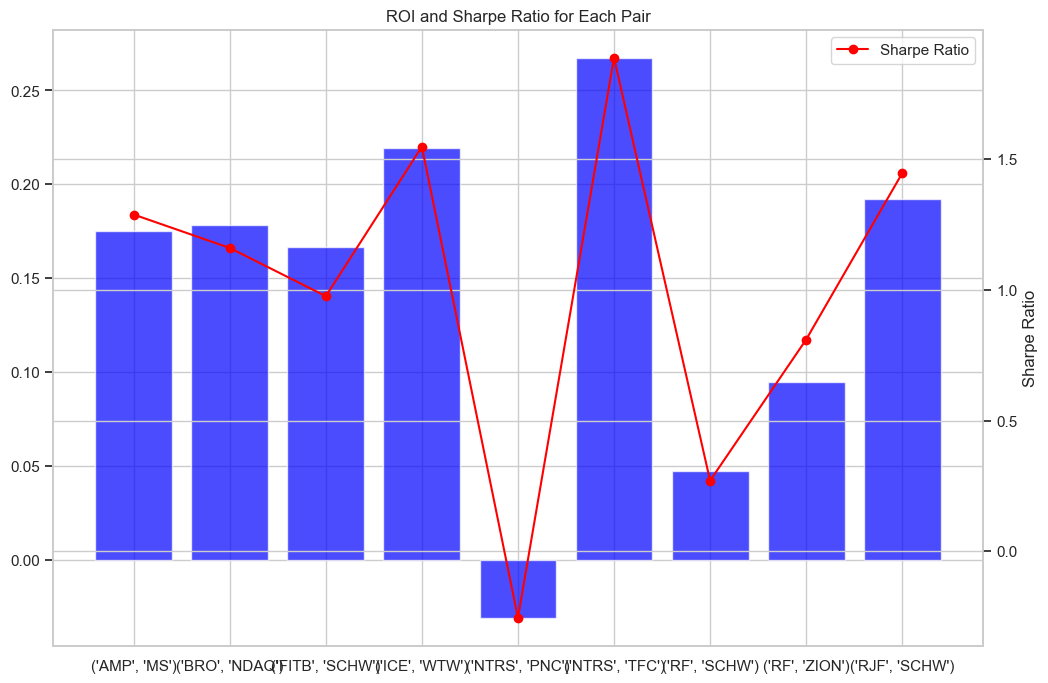

In [ ]:
# Extract the data for plotting
pair_labels = [str(i) for i in test_metrics.index]
roi_values = test_metrics['ROI']
sharpe_ratios = test_metrics['Sharpe Ratio']

# Set the figure size
plt.figure(figsize=(12,8))

# Plot the ROI as bars
plt.bar(pair_labels, roi_values, color='blue', alpha=0.7, label='ROI')

# Create a secondary y-axis for Sharpe ratio
ax = plt.gca().twinx()

# Plot the Sharpe ratio as a line
ax.plot(pair_labels, sharpe_ratios, color='red', marker='o', label='Sharpe Ratio')

# Set the axis labels
plt.xlabel('Pairs')
plt.ylabel('ROI')
ax.set_ylabel('Sharpe Ratio')

# Rotate the x-axis labels for better readability
plt.xticks(rotation='vertical')

# Set the title and legend
plt.title('ROI and Sharpe Ratio for Each Pair')
plt.legend()

# Show the plot
plt.show()

# Top pair selection

It is observed from the above graph that the NTRS/TFC pair is the most effective in terms of generating a positive Sharpe Ratio. it also has a low max drawdown of 7.1% and very high ROI of 26.7%. This pair also had good metrics using the training dataset. So this is our final choice of trading pair which gives us an extremely good Sharpe ratio of 1.89 for the test dataset.

Below we verify the relationship for this pair, visually inspect their co-movement, run a regression to ensure they are statistically linearly correlated (high R<sup>2</sup>), visually inspect the stationarity (mean-reversion) of the spread and re-confirm its stationarity using the ADF test.

In [ ]:
# Chosen pair for pairs trading strategy
asset1 = 'NTRS'
asset2 = 'TFC'
pair=(asset1,asset2)

# Data for chosen pair
train_chosen = pd.DataFrame()
train_chosen[asset1] = train[asset1]
train_chosen[asset2] = train[asset2]
train_chosen

,NTRS,TFC
Date,,
2014-09-17,56.896114,28.315168
2014-09-18,57.246120,28.596468
2014-09-19,56.676346,28.589060
2014-09-22,56.594963,28.352186
2014-09-23,56.204262,28.011656
...,...,...
2020-06-29,70.539551,32.550442
2020-06-30,73.350037,33.268085
2020-07-01,71.131241,32.258076


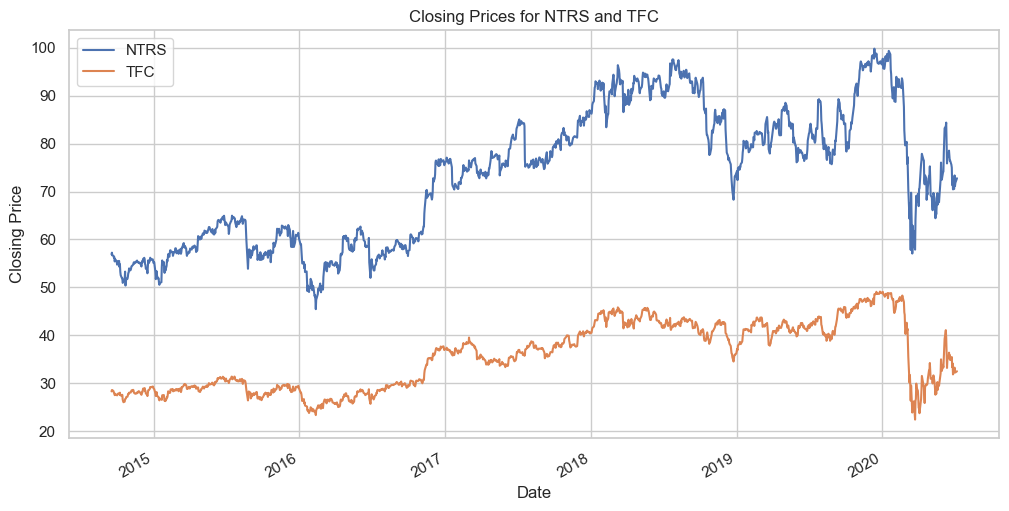

In [ ]:
# Plot closing prices for chosen pairs
ax = train_chosen[[asset1,asset2]].plot(figsize=(12, 6), title = 'Closing Prices for {} and {}'.format(asset1,asset2))
ax.set_ylabel("Closing Price")
ax.grid(True);

In [ ]:
# Run an OLS regression to calculate the beta and compute the spread
regmodel=sm.OLS(train_chosen[asset2], train_chosen[asset1]).fit()

(0.0, 1.0, 0.0, 1.0)

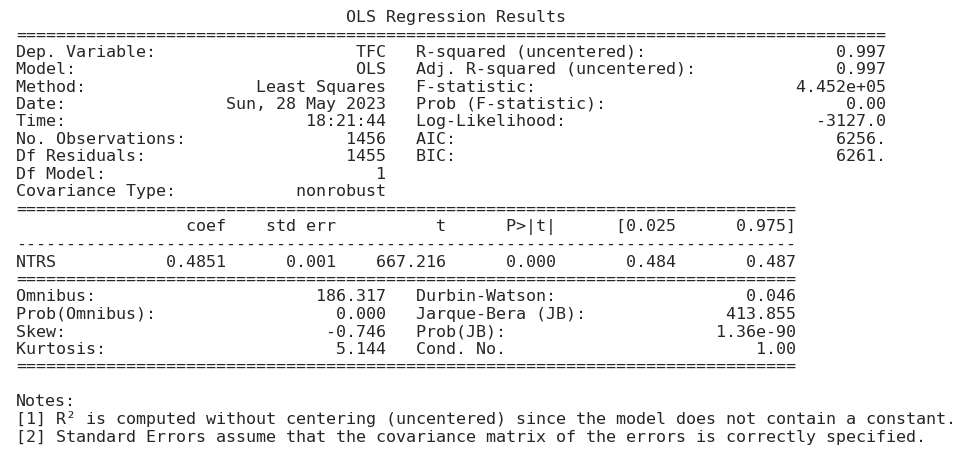

In [ ]:
# print regression summary results
plt.rc('figure', figsize=(8, 5))
plt.text(0.01, 0.05, str(regmodel.summary()), fontproperties = 'monospace')
plt.axis('off')

In [ ]:
print('Beta = ', regmodel.params[0])
# Use beta to calculate spread
spread = train_chosen[asset2] - regmodel.params[0] * train_chosen[asset1]

Beta =  0.4851334417241299


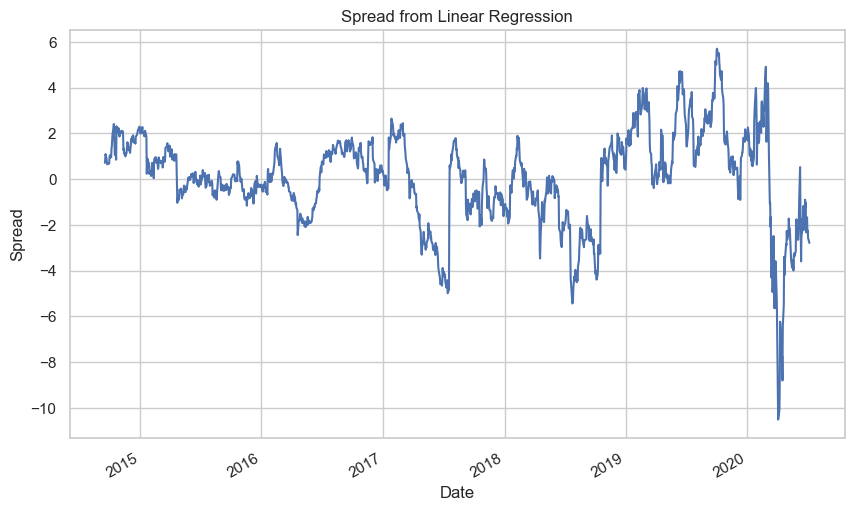

In [ ]:
# Visualize the spread
ax = spread.plot(figsize=(10, 6), title = "Spread from Linear Regression")
ax.set_ylabel("Spread")
ax.grid(True);

We observe that the spread for this pair is stationary, thus we can use it for our pairs trading strategy. We reconfirm the stationarity of the spread using the ADF test below.

In [ ]:
check_stationarity(spread)

True

# Comparision with buy-and-hold strategy

Below we compare the performance of our pairs trading strategy for our chosen pair NTRS/TFC and compare with it with buy-and-hold on each of the two assets individually as well as stock index SP500.

In [ ]:
# Data for chosen pair
test_chosen = pd.DataFrame()
test_chosen[asset1] = test[asset1]
test_chosen[asset2] = test[asset2]
test_chosen

,NTRS,TFC
Date,,
2020-07-07,71.972519,31.274652
2020-07-08,74.108124,31.292372
2020-07-09,70.641235,29.777365
2020-07-10,74.117371,31.186058
2020-07-13,75.411682,31.549301
...,...,...
2022-12-23,87.318855,41.354996
2022-12-27,87.189911,41.597748
2022-12-28,86.356689,41.316154


In [ ]:
# Download S&P 500 index data from Yahoo Finance, as a benchmark 
sp500_index_data = yf.download('^GSPC', start=test_chosen.index[0], end=end_date_1)
test_chosen['SP500'] = sp500_index_data['Close']
test_chosen

[*********************100%***********************]  1 of 1 completed


,NTRS,TFC,SP500
Date,,,
2020-07-07,71.972519,31.274652,3145.320068
2020-07-08,74.108124,31.292372,3169.939941
2020-07-09,70.641235,29.777365,3152.050049
2020-07-10,74.117371,31.186058,3185.040039
2020-07-13,75.411682,31.549301,3155.219971
...,...,...,...
2022-12-23,87.318855,41.354996,3844.820068
2022-12-27,87.189911,41.597748,3829.250000
2022-12-28,86.356689,41.316154,3783.219971


In [ ]:
# Generate returns for the two stocks and the index
# and the differential return between the two stocks for the pairs trading strategy
test_chosen2 = test_chosen.copy(deep=True)
test_chosen2[asset1+'_Return'] = test_chosen[asset1].pct_change()
test_chosen2[asset2+'_Return'] = test_chosen[asset2].pct_change()
test_chosen2['SP500_Return'] = test_chosen['SP500'].pct_change()
test_chosen2['Diff_Return'] = test_chosen2[asset2+'_Return'] - test_chosen2[asset1+'_Return']
test_chosen2

,NTRS,TFC,SP500,NTRS_Return,TFC_Return,SP500_Return,Diff_Return
Date,,,,,,,
2020-07-07,71.972519,31.274652,3145.320068,NaN,NaN,NaN,NaN
2020-07-08,74.108124,31.292372,3169.939941,0.029673,0.000567,0.007827,-0.029106
2020-07-09,70.641235,29.777365,3152.050049,-0.046781,-0.048415,-0.005644,-0.001633
2020-07-10,74.117371,31.186058,3185.040039,0.049208,0.047308,0.010466,-0.001901
2020-07-13,75.411682,31.549301,3155.219971,0.017463,0.011648,-0.009363,-0.005815
...,...,...,...,...,...,...,...
2022-12-23,87.318855,41.354996,3844.820068,0.007439,0.002589,0.005868,-0.004849
2022-12-27,87.189911,41.597748,3829.250000,-0.001477,0.005870,-0.004050,0.007347
2022-12-28,86.356689,41.316154,3783.219971,-0.009556,-0.006769,-0.012021,0.002787


In [ ]:
# Generate the strategy returns by multiplying the signals with the differential returns
test_returns = test_chosen2.iloc[:, 3:].dropna()
test_returns['Signal'] = test_signals[pair]
test_returns['Strategy_Return'] = test_returns['Signal'] * test_returns['Diff_Return']
test_returns

,NTRS_Return,TFC_Return,SP500_Return,Diff_Return,Signal,Strategy_Return
Date,,,,,,
2020-07-08,0.029673,0.000567,0.007827,-0.029106,0.0,-0.000000
2020-07-09,-0.046781,-0.048415,-0.005644,-0.001633,1.0,-0.001633
2020-07-10,0.049208,0.047308,0.010466,-0.001901,0.0,-0.000000
2020-07-13,0.017463,0.011648,-0.009363,-0.005815,0.0,-0.000000
2020-07-14,0.000981,-0.012075,0.013406,-0.013056,0.0,-0.000000
...,...,...,...,...,...,...
2022-12-23,0.007439,0.002589,0.005868,-0.004849,0.0,-0.000000
2022-12-27,-0.001477,0.005870,-0.004050,0.007347,0.0,0.000000
2022-12-28,-0.009556,-0.006769,-0.012021,0.002787,0.0,0.000000


In [ ]:
test_returns.drop(test_returns.columns[[3, 4]], axis=1, inplace=True)
test_returns.columns = ['NTRS', 'TFC', 'SP500', 'Strategy']
test_returns

,NTRS,TFC,SP500,Strategy
Date,,,,
2020-07-08,0.029673,0.000567,0.007827,-0.000000
2020-07-09,-0.046781,-0.048415,-0.005644,-0.001633
2020-07-10,0.049208,0.047308,0.010466,-0.000000
2020-07-13,0.017463,0.011648,-0.009363,-0.000000
2020-07-14,0.000981,-0.012075,0.013406,-0.000000
...,...,...,...,...
2022-12-23,0.007439,0.002589,0.005868,-0.000000
2022-12-27,-0.001477,0.005870,-0.004050,0.000000
2022-12-28,-0.009556,-0.006769,-0.012021,0.000000


In [ ]:
# Compute the metrics for the different strategies
passive_returns = test_returns
daily_returns = test_returns.mean()
std_dev = test_returns.std()
sharpe_ratio = np.sqrt(252) * (daily_returns / std_dev)  # Assuming 252 trading days in a year
max_drawdown = (test_returns.cumsum() - test_returns.cumsum().cummax()).min()
roi = daily_returns*252   # annualized returns

In [ ]:
# Tabulate the metrics
metrics = pd.DataFrame(index=test_returns.columns, columns=['Sharpe Ratio', 'Max Drawdown', 'ROI'])
metrics.iloc[:, 0] = sharpe_ratio
metrics.iloc[:,1] = max_drawdown
metrics.iloc[:,2] = roi
metrics

,Sharpe Ratio,Max Drawdown,ROI
NTRS,0.411390,-0.479995,0.129931
TFC,0.519653,-0.444644,0.170326
SP500,0.519294,-0.270691,0.098565
Strategy,1.886472,-0.071373,0.266988


We observe that while our pairs trading strategy with our chosen pair gives lower an ROI that is 3 times higher than passive buy-and-hold strategies on the stock index. More importantly, the Sharpe ratio which measures the risk-adjusted return is almost 4 times higher than of buy-and-hold. Finally, the max drawdown which is a key measure of downside risk associated with a strategy is 4 times lower for our pairs trading strategy compared to buy-and-hold. This gives us confidence that our pairs trading strategy would perform better than a passive buy-and-hold strategy.

Below we compare the evolution of $100 invested in our pairs trading strategy in NTRS/TFC pair vs buy-and-hold strategies on NTRS and TFC stocks and the SP500 index. This analysis assumes zero market friction in terms of transaction costs, bid-offer spreads etc.

In [ ]:
# Compare the evolution of $100 invested in our pairs trading strategy vs buy-and-hold in individual assets or the stock index

test_returns[asset1+'_Cumulative'] = test_returns[asset1].cumsum()
test_returns[asset1+'_Portfolio'] = 100*(1+test_returns[asset1+'_Cumulative'])
test_returns.at['2020-07-07', asset1+'_Portfolio'] = 100

test_returns[asset2+'_Cumulative'] = test_returns[asset2].cumsum()
test_returns[asset2+'_Portfolio'] = 100*(1+test_returns[asset2+'_Cumulative'])
test_returns.at['2020-07-07', asset2+'_Portfolio'] = 100

test_returns['SP500_Cumulative'] = test_returns['SP500'].cumsum()
test_returns['SP500_Portfolio'] = 100*(1+test_returns['SP500_Cumulative'])
test_returns.at['2020-07-07', 'SP500_Portfolio'] = 100

test_returns['Strategy_Cumulative'] = test_returns['Strategy'].cumsum()
test_returns['Strategy_Portfolio'] = 100*(1+test_returns['Strategy_Cumulative'])
test_returns.at['2020-07-07', 'Strategy_Portfolio'] = 100

test_returns

,NTRS,TFC,SP500,Strategy,NTRS_Cumulative,NTRS_Portfolio,TFC_Cumulative,TFC_Portfolio,SP500_Cumulative,SP500_Portfolio,Strategy_Cumulative,Strategy_Portfolio
Date,,,,,,,,,,,,
2020-07-08,0.029673,0.000567,0.007827,-0.000000,0.029673,102.967250,0.000567,100.056657,0.007827,100.782746,-0.000000,100.000000
2020-07-09,-0.046781,-0.048415,-0.005644,-0.001633,-0.017109,98.289101,-0.047848,95.215199,0.002184,100.218386,-0.001633,99.836691
2020-07-10,0.049208,0.047308,0.010466,-0.000000,0.032099,103.209932,-0.000540,99.945951,0.012650,101.265006,-0.001633,99.836691
2020-07-13,0.017463,0.011648,-0.009363,-0.000000,0.049562,104.956231,0.011107,101.110712,0.003288,100.328752,-0.001633,99.836691
2020-07-14,0.000981,-0.012075,0.013406,-0.000000,0.050543,105.054285,-0.000968,99.903180,0.016694,101.669389,-0.001633,99.836691
...,...,...,...,...,...,...,...,...,...,...,...,...
2022-12-27,-0.001477,0.005870,-0.004050,0.000000,0.314557,131.455651,0.417188,141.718771,0.241165,124.116473,0.661113,166.111308
2022-12-28,-0.009556,-0.006769,-0.012021,0.000000,0.305000,130.500011,0.410418,141.041827,0.229144,122.914410,0.661113,166.111308
2022-12-29,0.027797,0.015276,0.017461,-0.000000,0.332797,133.279714,0.425695,142.569454,0.246605,124.660543,0.661113,166.111308


In [ ]:
graph_returns = test_returns.copy(deep=True)
graph_returns.drop(graph_returns.columns[[0, 1, 2, 3, 4, 6, 8, 10]], axis=1, inplace=True)
graph_returns.columns = ['NTRS', 'TFC', 'SP500', 'Strategy']
graph_returns = graph_returns.sort_values('Date')
graph_returns

,NTRS,TFC,SP500,Strategy
Date,,,,
2020-07-07,100.000000,100.000000,100.000000,100.000000
2020-07-08,102.967250,100.056657,100.782746,100.000000
2020-07-09,98.289101,95.215199,100.218386,99.836691
2020-07-10,103.209932,99.945951,101.265006,99.836691
2020-07-13,104.956231,101.110712,100.328752,99.836691
...,...,...,...,...
2022-12-23,131.603322,141.131775,124.521436,166.111308
2022-12-27,131.455651,141.718771,124.116473,166.111308
2022-12-28,130.500011,141.041827,122.914410,166.111308


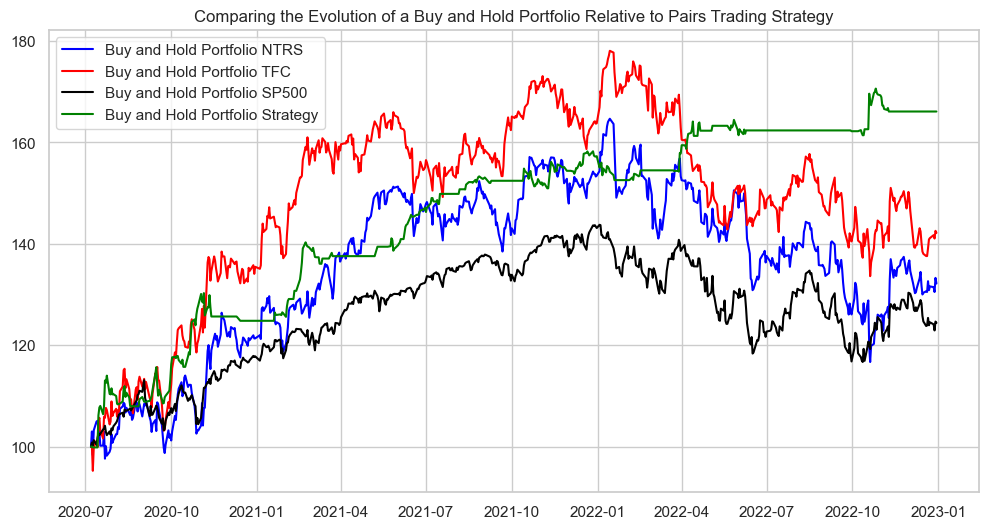

In [ ]:
# Plot the evolution of $100 invested in the various strategies

fig, ax = plt.subplots(figsize=(12,6))
ax.set_title('Comparing the Evolution of a Buy and Hold Portfolio Relative to Pairs Trading Strategy')
ax.plot(graph_returns[asset1], label = 'Buy and Hold Portfolio ' + asset1, color = 'blue')
ax.plot(graph_returns[asset2], label = 'Buy and Hold Portfolio ' + asset2, color = 'red')
ax.plot(graph_returns['SP500'], label = 'Buy and Hold Portfolio SP500', color = 'black')
ax.plot(graph_returns['Strategy'], label = 'Buy and Hold Portfolio Strategy', color = 'green')

ax.legend()
plt.show()

As we see form the graph above, our strategy perform in line with buy-and-hold strategies for most periods, but significantly outperforms when the two assets move in different direction and then correct to move together again.